<a href="https://colab.research.google.com/github/EugenioBugli/3DPointCloud/blob/main/PointCloud3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -q open3d
!pip install -q torch_scatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import train_test_split
from skimage import measure
import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
from torch_scatter import scatter_mean, scatter_max

import open3d as o3d
import plotly.graph_objects as go


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

from google.colab import drive
drive.mount("/content/drive")

drive_path = "/content/drive/MyDrive/CV/MPI-FAUST"
training_path = drive_path + "/training"
test_path = drive_path + "/test"

Using PyTorch version: 2.5.1+cu121  Device: cpu
Mounted at /content/drive


In [3]:
SAMPLING_TYPE = "RANDOM"
SAMPLING_SIZE = 1024*2
BATCH_SIZE = 5

IN_DIM_RES_PT = 64
FEATURES_DIM = 32
NUM_BLOCKS = 5
NUM_FC = 4
NUM_PLANES = 4
NUM_COORDINATES = 3

# 1] Dataset


In [4]:
class FAUST_Dataset(Dataset):
    """
        This class is used to load a partition of the FAUST dataset. Before using this you must access the file via DatasetFolder.
    """

    def __init__(self, scan_files, reg_files=None, sampling_type="RANDOM", sampling_size=1024, partition="TRAIN", transform=None):
        super(FAUST_Dataset, self).__init__()
        self.scan_files = scan_files # list of files .ply
        self.partition = partition
        self.reg_files = reg_files if partition in ["TRAIN", "VAL"] else None # list of files .ply
        self.sampling_type = sampling_type
        self.sampling_size = sampling_size
        self.transform = transform

        self.scans, self.regs = self.extractClouds()

    def __getitem__(self, index):
        if self.partition in ["TRAIN", "VAL"]:
            if self.transform:
                return self.transform(self.scans[index]).to(torch.float32).squeeze(0), self.transform(self.regs[index]).to(torch.float32).squeeze(0)
            return self.scans[index], self.regs[index]
        else: # test case
            if self.transform:
                return self.transform(self.scans[index]).to(torch.float32).squeeze(0)
            return self.scans[index]

    def __len__(self):
        return len(self.scan_files)

    def extractClouds(self):
        # we have to open the files .ply and transform them into point clouds:

        scans = []
        regs = []

        for i in range(len(self.scan_files)):
            s = o3d.io.read_point_cloud(self.scan_files[i])
            scans.append(self.SamplingFunction(s))

            if self.partition in ["TRAIN", "VAL"]:
                r = np.asarray(o3d.io.read_point_cloud(self.reg_files[i]).points)
                regs.append(r)

        return scans, regs if regs else None

    def plotCloud(self, cloud):
        """
        This function is used to plot the Point Cloud

        Args:
            cloud (np.array): Point Cloud

        Returns:
            None
        """
        if len(cloud.shape) == 3:
            # when using DataLoader you have a shape (1, SAMPLING_SIZE, 3)
            cloud = cloud[0]

        fig = go.Figure(
            data=[
            go.Scatter3d(
                x =cloud[:,0], y=cloud[:,1], z=cloud[:,2],
                mode = 'markers',
                marker = dict(size=0.5, color=[])
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True),
                )
            )
        )
        fig.show()

    def SamplingFunction(self, cloud):
        """
            This function is used to sample a small Subset of points from the Point Clouds inside our Dataset.

            @INPUT :
                > cloud : Point Cloud extracted from .ply file

            @OUTPUT :
                > sampled_cloud : Sampled Point Cloud
        """

        if self.sampling_type == 'RANDOM':
            points = np.asarray(cloud.points)
            indices = np.random.choice(len(points), size=self.sampling_size)
            sampled_cloud = points[indices]
        if self.sampling_type == 'IMPORTANCE':
            numOfNeighbors = 20
            # estimate normal vectors to the surface at each point of the cloud
            cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=numOfNeighbors))
            tree = o3d.geometry.KDTreeFlann(cloud) # faster
            # loop over the points and compute curvature
            curvature = np.zeros(len(cloud.points))
            for i in range(len(cloud.points)):
                # find indices of the neighbors
                [_ , idx, _] = tree.search_knn_vector_3d(cloud.points[i], numOfNeighbors)
                neighbors = np.asarray(cloud.points)[idx, :]
                # compute covariance matrix for each point
                covarianceMat = np.cov(neighbors.T)
                # extract eigenvalues
                eigen, _ = np.linalg.eigh(covarianceMat)
                # compute curvature
                curvature[i] = min(eigen) / sum(eigen)
            # extract the best SamplingPoints points
            maxCurvaturePoints = curvature.argsort()[-self.SamplingSize:]
            sampled_cloud = np.asarray(cloud.points)[maxCurvaturePoints]

        return sampled_cloud

# Save your preprocessed Dataset:
def SaveDataset(dataset, path):
    torch.save(dataset, "/content/drive/MyDrive/CV/PreProcessed/"+path)

# Load your preprocessed Dataset:
def LoadDataset(path):
    return torch.load("/content/drive/MyDrive/CV/PreProcessed/"+path, weights_only=False)


In [5]:
# use this to directly import the already pre-processed dataset

train_set = LoadDataset("train_set.pt")
val_set = LoadDataset("val_set.pt")
test_set = LoadDataset("test_set.pt")

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

# 1.1] Pre-Processing

In [ ]:
def openDataFiles(training_path, test_path, val_size):
    """
        This function is used to import all the .ply files from the folders. Training is partitioned into train and validation set directly here.
    """

    training_dataset = DatasetFolder(
        root = training_path,
        loader = o3d.io.read_point_cloud,
        extensions = ('ply',),
        allow_empty = True,
        )

    test_dataset = DatasetFolder(
        root = test_path,
        loader = o3d.io.read_point_cloud,
        extensions = ('ply',),
        allow_empty = True,
    )

    unsorted_training_scan_files = [sample for sample, t in training_dataset.samples if t == 2]
    training_scan_files = sorted(unsorted_training_scan_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    unsorted_training_reg_files = [sample for sample, t in training_dataset.samples if t == 1]
    training_reg_files = sorted(unsorted_training_reg_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # perform train-validation split :

    train_scan_files, val_scan_files, train_reg_files, val_reg_files = train_test_split(training_scan_files, training_reg_files, test_size=val_size, random_state=15)


    unsorted_test_scan_files = [sample for sample, t in test_dataset.samples if t == 1]
    test_scan_files = sorted(unsorted_test_scan_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    test_reg_files = test_scan_files # check here
    # we don't have any registration for the test set --> use instead the complete point cloud


    return train_scan_files, train_reg_files, val_scan_files, val_reg_files, test_scan_files, test_reg_files


In [ ]:
# import all the files from folders + perform the split
train_scan_files, train_reg_files, val_scan_files, val_reg_files, test_scan_files, test_reg_files = openDataFiles(training_path, test_path, val_size=0.2)

train_set = FAUST_Dataset(train_scan_files, train_reg_files, sampling_type=SAMPLING_TYPE, sampling_size=SAMPLING_SIZE, partition="TRAIN", transform=transforms.ToTensor())
val_set = FAUST_Dataset(val_scan_files, val_reg_files, sampling_type=SAMPLING_TYPE, sampling_size=SAMPLING_SIZE, partition="VAL", transform=transforms.ToTensor())
test_set = FAUST_Dataset(test_scan_files, test_reg_files, sampling_type=SAMPLING_TYPE, sampling_size=SAMPLING_SIZE, partition="TEST", transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

# 1.2] Visualization

In [6]:
def Plot2D(cloud2d):
    figure2D = plt.figure(figsize=(7,7))
    axes2D = plt.axes()
    axes2D.scatter(cloud2d[:, 0], cloud2d[:, 1], alpha=0.5)
    plt.show()

In [7]:
def voxel2Numpy(voxel):
    voxels = voxel.get_voxels()
    # notice that the coordinates are in the voxel grid !
    indices = np.stack(list(vx.grid_index for vx in voxels))
    return indices

In [ ]:
# add noise to a point cloud:
for batch in train_loader:
    eg = batch[0][0]
    eg = (eg - eg.min())/(eg.max() - eg.min() + 10e-6)

    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(eg)
    o3d.visualization.draw_plotly([pc])

    eg_noise = eg + np.random.normal(0, 0.01, eg.shape) # gaussian noise
    pc_noise = o3d.geometry.PointCloud()
    pc_noise.points = o3d.utility.Vector3dVector(eg_noise)
    o3d.visualization.draw_plotly([pc_noise])

    pc.scale(1 / np.max(pc.get_max_bound() - pc.get_min_bound()), center=pc.get_center())

    # try downsampling the point cloud that you have with 3D voxels
    # all the points belonging to the cloud are bucketed into voxels and then each occupied voxel generates exactly one point by averaging all points inside.

    voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(pc, voxel_size=0.025)
    vec3d = o3d.utility.Vector3dVector(eg)
    # use this to check if your points are inside the voxel
    print(np.asarray(voxel.check_if_included(vec3d)))

    print((voxel.get_voxels()[0]).grid_index)
    fig = go.Figure()
    voxel = np.asarray(voxel.get_voxels())
    points = np.asarray([v.grid_index for v in voxel])
    fig.add_trace(
        go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode='markers',
            marker=dict(size=3, color='green', opacity=0.5)
    ))
    fig.show()

    break


[ True  True  True ...  True  True  True]
[ 5 14  4]


# 2] Encoder

## 2.1) ResBlock + Functions

In [ ]:
class ResBlock(nn.Module):
    """
        This class is used to define a Residual Block, which is one of the main component of the ResNetPointNet architecture
    """

    def __init__(self, in_dim=64, n_points=1024, h_dim=32, out_dim=64):
        super(ResBlock, self).__init__()

        self.n_points = n_points

        #> First part of the Block

        self.fc1 = nn.Linear(
            in_dim,
            h_dim
        )
        self.bn1 = nn.BatchNorm1d(self.n_points)

        #> Second part of the Block

        self.fc2 = nn.Linear(
            h_dim,
            out_dim
        )
        self.bn2 = nn.BatchNorm1d(self.n_points)

        #> Skip connection

        if in_dim != out_dim:
            # size mismatch (never happen in my case)
            self.residual = nn.Linear(in_dim, out_dim)
        else:
            # same size
            self.residual = None


    def forward(self, x):
        # Input: (b,p,in_dim) = (b,p,64)

        first_part = F.relu(self.bn1(self.fc1(x))) # (b,p,64) -> (b,p,32)

        second_part = self.bn2(self.fc2(first_part)) # (b,p,32) -> (b,p,64)

        if self.residual is None:
            # no size mismatch
            res = x # (b,p,64)
        else:
            # transformation if there is a size mismatch in_dim != out_dim
            res = self.residual(x) # (b,p,in_dim) -> (b,p,64)

        # add residual connection
        third_part = second_part + res # (b,p,64) -> (b,p,64)

        return F.relu(third_part)

In [ ]:
# specify how local max pooling is performed:
# this type of operation aims to perform pooling within a particular neighborhood of the point cloud
# this neighborhood must be specified as a 2 structure ?

## 2.2) ResNetPointNet

In [8]:
def CloudNormalization(input_cloud):
    # normalize cloud in order to have it in [0,1]
    min = input_cloud.min()
    max = input_cloud.max()
    norm_cloud = (input_cloud - min)/(max-min)
    return norm_cloud

def CanonicalProjection(input_cloud):
    # gives you a dict with all 3 canonical projections (xy, xz, yz)
    xy_proj = CloudNormalization(input_cloud[:,:,[0,1]]) # XY plane (view from above)
    xz_proj = CloudNormalization(input_cloud[:,:,[0,2]]) # XZ plane (view from long side)
    yz_proj = CloudNormalization(input_cloud[:,:,[1,2]]) # YZ plane (view from short side)
    return {"xy": xy_proj, "xz": xz_proj, "yz": yz_proj}

def DivideInBuckets(input_cloud_proj, resolution):
    # in input we have the canonical projection of the input cloud and the resolution of our buckets
    # map 2D coordinates into one dimension
    xy_buck = (input_cloud_proj["xy"]*resolution).long()
    xz_buck = (input_cloud_proj["xz"]*resolution).long()
    yz_buck = (input_cloud_proj["yz"]*resolution).long()
    return {"xy": xy_buck[:,:,0] + resolution*xy_buck[:,:,1], "xz": xz_buck[:,:,0] + resolution*xz_buck[:,:,1], "yz": yz_buck[:,:,0] + resolution*yz_buck[:,:,1]}

torch.Size([5, 2048, 2]) torch.Size([5, 2048])
tensor([14, 15, 16, 24, 25, 26, 34, 35, 36, 44, 45, 46, 54, 55, 56, 57, 63, 64,
        65, 66, 67, 73, 74, 75, 76, 77, 84, 85, 86, 87, 95, 96])
tensor(55)


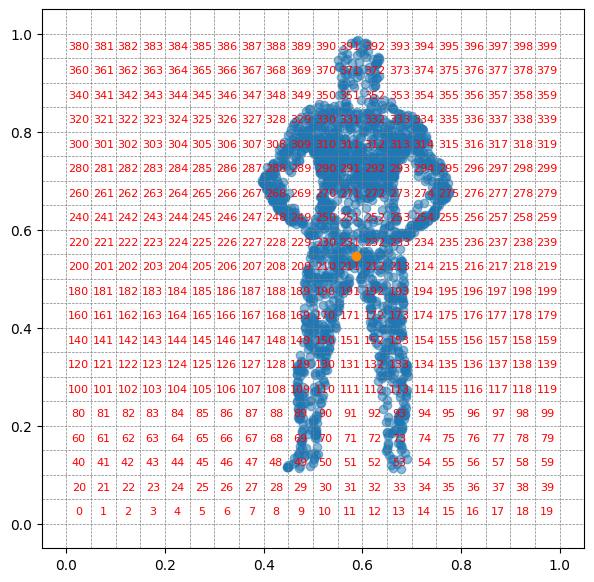

In [42]:
def LocalMaxPooling(input_cloud):
    # given the 3D point cloud I need to project them into a 2D grid. In this way I can define the neighborhood to perform local pooling
    # voxelization is not a good idea since I will lose details (all points are averaged into a voxel)
    canon_proj = CanonicalProjection(input_cloud)
    # we need to divide this 2D planes into buckets and the perform inside each of them the pooling operation
    indices = DivideInBuckets(canon_proj, resolution=10)
    return canon_proj, indices

for batch in train_loader:
    eg = batch[0]
    eg = (eg - eg.min())/(eg.max() - eg.min() + 10e-6)

    proj, indices = LocalMaxPooling(eg)
    print(proj["xy"].shape, indices["xy"].shape)
    resolution = 20

    figure2D = plt.figure(figsize=(7,7))
    axes2D = plt.axes()
    axes2D.scatter(proj['xy'][0][:, 0], proj['xy'][0][:, 1], alpha=0.5)
    for i in range(resolution + 1):
        plt.axvline(x=i/resolution, color='gray', linestyle='--', linewidth=0.5)
        plt.axhline(y=i/resolution, color='gray', linestyle='--', linewidth=0.5)
    for xi in range(resolution):
        for yi in range(resolution):
            bucket_idx = xi + resolution*yi
            # Center of the cell
            x_center = (xi + 0.5)/resolution
            y_center = (yi + 0.5)/resolution
            plt.text(x_center, y_center, str(bucket_idx), fontsize=8, color='red', ha='center', va='center')
    print(torch.unique(indices["xy"][0]))
    axes2D.plot(proj['xy'][0][0][0], proj['xy'][0][0][1], color="darkorange", marker='o')
    print(indices["xy"][0][0])
    plt.show()
    break

In [ ]:
class ResNetPointNet(nn.Module):
    """
        This class is used to define the PointNet model used to form a feature embedding for each point in the Point Cloud given in input.
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3)

            > Fully Connected Layer (3, in_dim=64)
            > 5 Residual Blocks with Local Pooling and Concatenation
            > Fully Connected Layer (out_dim=32, out_dim=32)

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """

    def __init__(self, in_dim=64, n_points=1024, res_dim=32, out_dim=32, n_blocks=5):
        super(ResNetPointNet, self).__init__()

        self.fc1 = nn.Linear(3, in_dim)

        self.res = nn.ModuleList([
            ResBlock(in_dim, n_points, res_dim, out_dim) for n_res in range(n_blocks)
        ])

        self.fc2 = nn.Linear(out_dim, out_dim)

    def forward(self, x):
        # Input: (b,p,3)

        # Extract Normalized coordinates and indices to perform local pooling

        norm_coord = CoordinateNormalization(x) # (b,p,2)
        coord_indices = PlaneCoordinate2Index(norm_coord) # (b,p,2)

        # First FC Layer
        fc1 = F.relu(self.fc1(x)) # (b,p,3) -> (b,p,64)

        # First ResBlock
        res = self.res[0](fc1) # (b,p,64) -> (b,p,32)

        # 2-5 ResBlock
        for res_block in self.res[1:]:
            # Local Pooling
            pool = LocalPooling(norm_coord, coord_indices, res) # (b,p,32)
            # Concatenation
            concat = torch.cat([res, pool], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)
            # following residual block
            res = res_block(concat) # (b,p,64) -> (b,p,32)

        # Last FC Layer
        final = F.relu(self.fc2(res)) # (b,p,32) -> (b,p,32)

        #   print(f"ResNetPointNet : input ({x.shape}) ---> output ({final.shape}) \n")

        return final

## 2.3) Plane Predictor

In [ ]:
class SimplePointNet(nn.Module):
    """
        This class is used to define a simple variant of the PointNet Model, which is one of the main components of the Plane Predictor Network.
        This Network will provide us a global context of the Input Point Clouds
        Architecture Design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent the Input Point Clouds

            > Fully Connected Layer (3, 64)

              |> Fully Connected Layer (64, 32)
            2*|> Global Max Pooling
              |> Concatenation btw Pooled and unpooled features

            > Fully Connected Layer (64, 32)
            > Global Max Pooling

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be used by the rest of the Plane Predictor
    """

    def __init__(self, batch_size, in_dim=64, n_points=1024, hid_dim=32, out_dim=64):
        super(SimplePointNet, self).__init__()

        self.batch_size = batch_size
        self.n_points = n_points

        self.initial_fc = nn.Linear(in_features=3, out_features=in_dim)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.fc2 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.final_fc = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

    def forward(self, x):

        x = F.relu(self.initial_fc(x)) # (b,p,3) --> (b,p,64)

        x1 = F.relu(self.fc1(x)) # (b,p,64) --> (b,p,32)
        x1_t = x1.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x1 = self.pool(x1_t) # (b,32,p) -> (b,32,1)
        exp_pool_x1 = pool_x1.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x1 = torch.cat([x1, exp_pool_x1], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        x2 = F.relu(self.fc2(concat_x1)) # (b,p,64) -> (b,p,32)
        x2_t = x2.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x2 = self.pool(x2_t) # (b,32,p) -> (b,32,1)
        exp_pool_x2 = pool_x2.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x2 = torch.cat([x2, exp_pool_x2], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        pre_pool_out = F.relu(self.final_fc(concat_x2)) # (b,p,64) -> (b,p,32)
        pre_pool_out_t = pre_pool_out.transpose(1,2) # (b,p,32) -> (b,32,p)
        out = self.pool(pre_pool_out_t) # (b,32,p) -> (b,32,1)

        #   print(f"SimplePointNet : input ({x.shape}) ---> output ({out.transpose(1,2).shape}) \n")
        return out.transpose(1,2) # (b,32,1) -> (b,1,32)

In [ ]:
class PlanePredictor(nn.Module):
    """
        This class is used to define the Plane Predictor of our Architecture, which will predict the plane parameters of L dynamic planes
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent Point Clouds

            > Simple PointNet which learns the global context of the input point clouds
            > This information is encoded into one global feature by using Max Pooling
            > 4 Fully Connected Layers with hidden dimension = 32
            > L Shallow Networks with hidden dimension = 3 which will give us the Predicted Plane Parameters
            > L Fully Connected Layers with 1 layer and hidden dimension = D (same as point cloud encoder hidden dimension)
            > Each plane-specific feature is expanded to N x D to match the output of the point cloud encoder, which will be summed together


            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be summed up to the features given by the ResNetPointNet before
                      being processed into U-Net

    """
    def __init__(self, in_dim=32, n_points=1024, n_fc=4, L=4):
        super(PlanePredictor, self).__init__()

        self.pointNet = SimplePointNet(batch_size=BATCH_SIZE, in_dim=IN_DIM_RES_PT, n_points=n_points, hid_dim=in_dim, out_dim=IN_DIM_RES_PT)
        self.n_points = n_points

        # 4 FC layers with hidden dim = 32

        self.four_fc = nn.ModuleList(
            [nn.Linear(in_dim, in_dim) for i in range(n_fc)]
        )

        # Plane parameters (L shallow networks with hidden dim = 3)

        self.first_shallow = nn.Linear(in_dim, 3)
        self.shallows = nn.ModuleList(
            [nn.Linear(3, 3) for i in range(L-1)]
        )

        # L FC layers with hidden dim = 32

        self.first_fc = nn.Linear(3, in_dim)
        self.L_fc = nn.ModuleList(
            [nn.Linear(in_dim, in_dim) for i in range(L-1)]
        )

    def forward(self, x):

        flc = self.pointNet(x) # (b,p,3) -> (b,1,32)

        # 4 FC layers with hidden dim = 32

        for fc in self.four_fc:
            flc = F.relu(fc(flc))  # (b,1,32) -> (b,1,32)

        # Plane parameters ( L Shallow Networks )

        first_sh = F.relu(self.first_shallow(flc)) # (b,1,32) -> (b,1,3)
        shal = first_sh
        for s in self.shallows:
            shal = F.relu(s(shal)) # (b,1,3) -> (b,1,3)

        # L FC networks dim = 32

        first_fc_L = F.relu(self.first_fc(shal)) # (b,1,3) -> (b,1,32)
        L_fully = first_fc_L
        for fc in self.L_fc:
            L_fully = F.relu(fc(L_fully))  # (b,1,32) -> (b,1,32)

        # Expansion

        out = L_fully.expand(x.shape[0], self.n_points, first_fc_L.shape[-1]) # (b,1,32) -> (b,p,32)

        #   print(f"PlanePredictor : input ({x.shape}) ---> output ({out.shape}) \n")
        return out

## 2.4) Construct Projected Feature Planes

$R = I + skew(v) + skew(v)^2 \cdot \frac{1-\mathcal{k} \cdot \mathcal{\hat{n}}} {||v||^2}$

In [ ]:
# we need to project the encoded features (the output of the previous step aka 2.2+2.3) onto the dynamic planes with a defined size of H x W grid and then
# apply max-pooling for the features inside each cell
# 3 different operations must be employed to keep them inside H x W grids.
# > Basis Change
# > Orthographic Projection (map 3D points into 2D plane coordinates)
# > Normalization

def ChangeOfBasis():
    # reorientation of the coordinate system to align it with the dynamic plane (needed if you are not using the 3 canonical planes)


## 2.5) UNet

In [ ]:
class UNet(nn.Module):
    """
        This class is used to define the UNet of our Architecture, which is the final part of our Encoder.
        Architecture design:

        @ INPUT: Tensor of shape (batch_size, 32, 64, 64)
            # Encoder:

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

            # BottleNeck:

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

            # Decoder:

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > Conv2D

        @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """
    def __init__(self, in_dim=32, out_dim=32, features_dim=64, n_points=1024):
        super(UNet, self).__init__()

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # Encoder

        ## Block 1

        self.e_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
        )

        self.p_1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 2

        self.e_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
        )

        self.p_2 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 3

        self.e_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
        )

        self.p_3 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 4

        self.e_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
        )

        self.p_4 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # Bottleneck

        self.b = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*16,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*16,
                out_channels=features_dim*16,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*16),
            nn.ReLU(),
        )

        # Decoder

        ## Block 1

        self.d_upconv1 = nn.ConvTranspose2d(
            in_channels=features_dim*16,
            out_channels=features_dim*8,
            kernel_size=2,
            stride=2)

        self.d_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*16,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
        )

        ## Block 2

        self.d_upconv2 = nn.ConvTranspose2d(
            in_channels=features_dim*8,
            out_channels=features_dim*4,
            kernel_size=2,
            stride=2)

        self.d_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
        )

        ## Block 3

        self.d_upconv3 = nn.ConvTranspose2d(
            in_channels=features_dim*4,
            out_channels=features_dim*2,
            kernel_size=2,
            stride=2)

        self.d_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
        )

        ## Block 4

        self.d_upconv4 = nn.ConvTranspose2d(
            in_channels=features_dim*2,
            out_channels=features_dim,
            kernel_size=2,
            stride=2)

        self.d_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
        )

        self.final = nn.Conv2d(
                in_channels=features_dim,
                out_channels=out_dim,
                kernel_size=1
            )



    def forward(self, x):

        enc1 = self.e_1(x)
        #print(f"Encoder block 1 : input ({x.shape}) ---> output ({enc1.shape})")
        enc2 = self.e_2(self.p_1(enc1))
        #print(f"Encoder block 2 : input ({self.p_1(enc1).shape}) ---> output ({enc2.shape})")
        enc3 = self.e_3(self.p_2(enc2))
        #print(f"Encoder block 3 : input ({self.p_2(enc2).shape}) ---> output ({enc3.shape})")
        enc4 = self.e_4(self.p_3(enc3))
        #print(f"Encoder block 4 : input ({self.p_3(enc3).shape}) ---> output ({enc4.shape})")

        bottle = self.b(self.p_4(enc4))
        #print(f"BottleNeck : input ({self.p_4(enc4).shape}) ---> output ({bottle.shape})")

        dec1 = self.d_upconv1(bottle)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec1 = self.d_1(dec1)
        #print(f"Decoder block 1 : input ({bottle.shape}) ---> output ({dec1.shape})")
        dec2 = self.d_upconv2(dec1)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.d_2(dec2)
        #print(f"Decoder block 2 : input ({dec1.shape}) ---> output ({dec2.shape})")
        dec3 = self.d_upconv3(dec2)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.d_3(dec3)
        #print(f"Decoder block 3 : input ({dec2.shape}) ---> output ({dec3.shape})")
        dec4 = self.d_upconv4(dec3)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.d_4(dec4)
        #print(f"Decoder block 4 : input ({dec3.shape}) ---> output ({dec4.shape})")
        out = self.final(dec4)
        #print(f"Final : input ({dec4.shape}) ---> output ({out.shape})")


        #   print(f"UNet : input ({x.shape}) ---> output ({out.shape}) \n")

        return out

## 2.6) Complete Architecture

In [ ]:
class Encoder(nn.Module):

    def __init__(self, in_dim=64, out_dim=32, n_points=1024, n_blocks=5, num_planes=4, num_fc=4):
        super(Encoder, self).__init__()

        self.resnet_pointnet = ResNetPointNet(in_dim=in_dim, n_points=n_points, out_dim=out_dim, n_blocks=n_blocks)
        self.plane_predictor = PlanePredictor(in_dim=out_dim, n_points=n_points, n_fc=num_fc, L=num_planes)
        self.UNet = UNet(in_dim=out_dim, out_dim=out_dim, features_dim=in_dim, n_points=n_points)


    def forward(self, x):
        resnet = self.resnet_pointnet(x)
        plane_pred = self.plane_predictor(x)
        # here we need to perform features projection
        features_proj = # something(x, resnet + plane_pred)
        out = self.UNet(features_proj)
        return out

# 3] Decoder

In [ ]:
class Decoder(nn.Module):
    """
        This class is used to define the Decoder Network. The architecture is composed by 5 ResNet blocks with hidden dimension 32 followed by a small
        Fully Connected netowrk that returns the Occupancy prediction.
        Given the features vector in input, we have to perform Bilinear Interpolation before the ResNet blocks.
        Architecture design:

            @ INPUT:

                > Tensor of shape [input_cloud] (batch_size, n_points=1024, 3)
                > Tensor of shape [features vector] (batch_size, features=32, resolution=64, resolution=64)


            @ OUTPUT:

                > Tensor of shape [occupancy prediction] (batch_size, n_points=1024, 1)
    """

    def __init__(self, in_dim=32, n_points=1024, n_blocks=5):
        super(Decoder, self).__init__()

        self.res_blocks = nn.ModuleList(
            [ResBlock(in_dim, n_points, in_dim, in_dim) for i in range(n_blocks)]
        )
        self.occupancy_pred = nn.Sequential(
            nn.Linear(in_dim, in_dim//2),
            nn.ReLU(),
            nn.Linear(in_dim//2, 1),
            nn.Sigmoid(),
        )

    def forward(self, input, input_features):
        x = input

        # Normalize your Input Cloud to 2D and Apply Bilinear Interpolation

        norm_cloud = CoordinateNormalization(input)

        # print(f"norm_cloud : ({norm_cloud.shape}), unsqueeze : ({norm_cloud.unsqueeze(2).shape})")

        interpolated_features = F.grid_sample(input_features, norm_cloud.unsqueeze(2), mode='bilinear', align_corners=True)

        # print(f"interpolated_features : ({interpolated_features.shape}), squeeze : ({interpolated_features.squeeze(-1).shape})")

        x = interpolated_features.squeeze(-1).transpose(2,1)

        for res_block in self.res_blocks:
            x = res_block(x)

        occupancy = self.occupancy_pred(x)
        # print(f"occupancy : ({occupancy.shape})")

        #   print(f"Decoder : ({input_features.shape}) --> ({occupancy.shape}) \n")

        return occupancy

# 4] Metrics

<font color="orange"> Chamster Distance: </font> $
CD(A, B) = \frac{1}{|A|} \sum_{a \in A} \min_{b \in B} \|a - b\|_2^2 + \frac{1}{|B|} \sum_{b \in B} \min_{a \in A} \|b - a\|_2^2
$

In [ ]:
# Chamster Distance
def ChamsterDistance(input_cloud, pred_cloud):
    """
        This function is used to compute the Chamster Distance between the input cloud and the predicted cloud.
        This metrics is composed by sum of the distances from each point in input_cloud to its nearest neighbor in pred_cloud
        plus the distances from each point in pred_cloud to its nearest neighbor in input_cloud.
        We would like to MINIMIZE this metric.

        @ INPUT :
            > tensor of shape (batch_size, num_points, 3)
            > tensor of shape (batch_size, num_points, 3)

        @ OUTPUT :
            > tensor of shape (batch_size, num_points, 1)
    """

    A = input_cloud.detach().cpu()
    B = pred_cloud.detach().cpu()

    dists_A_to_B = torch.cdist(A, B, p=2)
    dists_B_to_A = torch.cdist(B, A, p=2)

    print(f"dists_A_to_B : ({dists_A_to_B.shape})")
    print(f"dists_B_to_A : ({dists_B_to_A.shape})")

    min_A_to_B = torch.min(dists_A_to_B, dim=1)[0]
    min_B_to_A = torch.min(dists_B_to_A, dim=1)[0]

    print(f"min_A_to_B : ({min_A_to_B.shape})")
    print(f"min_B_to_A : ({min_B_to_A.shape})")

    CD = torch.mean(min_A_to_B) + torch.mean(min_B_to_A)

    print(f"Chamster Distance : ({CD.shape}) \n")

    return CD

<font color="orange"> Volumetric IOU: </font> $ IoU(A', B') = \frac{|A' \cap B'|}{|A' \cup B'|}$

In [ ]:
# Intersection Over Union
def VolumetricIOU(real_cloud, pred_cloud):
    """
        This function is used to compute the Intersection Over Union between two volumes

        @ INPUT :
            > tensor of shape (batch_size, ...) (actually binary voxel grid)
            > tensor of shape (batch_size, ...) (actually binary voxel grid)

        @ OUTPUT :
            > float
    """
    real_cloud = np.array(real_cloud, dtype=np.bool)
    pred_cloud = np.array(pred_cloud, dtype=np.bool)

    return np.sum(real_cloud & pred_cloud) / np.sum(pred_cloud) + np.sum(real_cloud)

<font color="orange"> F-Score: </font>

In [ ]:
# F-score

<font color="orange"> Normal Consistency: </font>

In [ ]:
# Normal Consistency

# 5] Training

In [ ]:
def OccupancyGroundTruth(sampled_points, registration_points, threshold=0.05):
    """
        This function is used to obtain the occupancy ground truth from the registration of the input cloud.
        This is crucial since it will be the quantity compared to the occupancy prediction.
        The dataset provide the registration of the input cloud, which is the set of point on the surface of each figure.

        @ INPUT :
            > sampled_points: tensor of shape (batch_size, num_points=1024, 3)
            > registration_points: tensor of shape (batch_size, num_points_reg , 3)
            > threshold: float, default=0.05

        @ OUTPUT :
            > tensor of shape (batch_size, num_points, 1)
    """
    # compute the distance between each of the sampled points and all the registration's points
    dis = sampled_points[:, :, None, :] - registration_points[:, None, :, :]
    distances = torch.norm(dis, dim=-1)
    # find the minimum distances aka the distance between each point and its nearest neighbor
    min_distances, _ = torch.min(distances, dim=2)
    return (min_distances < threshold).float().unsqueeze(-1)

In [ ]:
class CompleteArchitecture(nn.Module):

    def __init__(self, in_dim=64, out_dim=32, n_points=1024, n_blocks=5, num_planes=4, num_fc=4):
        super(CompleteArchitecture, self).__init__()
        self.encoder = Encoder(in_dim, out_dim, n_points, n_blocks, num_planes, num_fc)
        self.decoder = Decoder(out_dim, n_points, n_blocks)

    def forward(self, x):
        out_enc = self.encoder(x)
        out_dec = self.decoder(x, out_enc)
        return out_dec

In [ ]:
completeModel = CompleteArchitecture(in_dim=IN_DIM_RES_PT, out_dim=FEATURES_DIM, n_points=SAMPLING_SIZE, n_blocks=NUM_BLOCKS, num_planes=NUM_PLANES, num_fc=NUM_FC)
completeModel = completeModel.to(device)
BCE = nn.BCELoss() # later change this and use the version with logits (remember to delete sigmoid in the occupancy pred network)
optimizer = torch.optim.Adam(completeModel.parameters(), lr=1e-4) # currently using the same from the paper
num_epochs = 25

for epoch in range(num_epochs):

    completeModel.train()

    train_loss = 0.0

    train_loss_cnt = []
    val_loss_cnt = []

    # add other metrics container (IOU, chamfer, ...)
    for batch in train_loader:
        optimizer.zero_grad()
        sampled_cloud, ground_truth = batch[0].to(device), batch[1].to(device)
        # use the gpu
        occupancy_pred = completeModel(sampled_cloud)
        # calculate the loss between the occupancy prediction and the real occupancy
        real_occupancy =  OccupancyGroundTruth(sampled_cloud, ground_truth)

        loss = BCE(occupancy_pred, real_occupancy)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_cnt.append(avg_train_loss)


    completeModel.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sampled_cloud, ground_truth = batch[0].to(device), batch[1].to(device)
            # use the gpu
            occupancy_pred = completeModel(sampled_cloud)
            real_occupancy = OccupancyGroundTruth(sampled_cloud, ground_truth)
            loss = BCE(occupancy_pred, real_occupancy)
            val_loss += loss.item()
            # perform the reconstruction
            # meshes = Reconstruction(occupancy_pred, sampled_cloud)
            # compute other metrics

    avg_val_loss = val_loss / len(val_loader)
    val_loss_cnt.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # save the model if it's better than the last one

    """
    torch.save(
        {
        'model_state_dict': completeModel.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        },
        'model.pt'
    )
    """


Epoch [1/25], Train Loss: 0.5437, Val Loss: 0.5872
Epoch [2/25], Train Loss: 0.3200, Val Loss: 0.4081
Epoch [3/25], Train Loss: 0.2150, Val Loss: 0.2421
Epoch [4/25], Train Loss: 0.1468, Val Loss: 0.1307
Epoch [5/25], Train Loss: 0.0986, Val Loss: 0.0489
Epoch [6/25], Train Loss: 0.0652, Val Loss: 0.0502
Epoch [7/25], Train Loss: 0.0451, Val Loss: 0.0298
Epoch [8/25], Train Loss: 0.0299, Val Loss: 0.0244
Epoch [9/25], Train Loss: 0.0217, Val Loss: 0.0205
Epoch [10/25], Train Loss: 0.0155, Val Loss: 0.0192
Epoch [11/25], Train Loss: 0.0123, Val Loss: 0.0108
Epoch [12/25], Train Loss: 0.0096, Val Loss: 0.0105
Epoch [13/25], Train Loss: 0.0078, Val Loss: 0.0103
Epoch [14/25], Train Loss: 0.0062, Val Loss: 0.0078
Epoch [15/25], Train Loss: 0.0056, Val Loss: 0.0059
Epoch [16/25], Train Loss: 0.0047, Val Loss: 0.0061
Epoch [17/25], Train Loss: 0.0040, Val Loss: 0.0062
Epoch [18/25], Train Loss: 0.0034, Val Loss: 0.0041
Epoch [19/25], Train Loss: 0.0032, Val Loss: 0.0050
Epoch [20/25], Train 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_cnt, label='Train')
plt.plot(val_loss_cnt, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training and Validation Losses')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig('losses.png')

# 6] Evaluation

We first discretize the volumetric space at an initial resolution and evaluate the occupancy network fθ (p, x) for all p in this grid.
We mark all grid points p as <font color="orange"> occupied </font> for which fθ(p,x) is bigger or equal to some threshold τ. Next, we mark all voxels as <font color="olive"> active </font> for which **at least
two adjacent grid points** have differing occupancy predictions. These are the voxels which would intersect the mesh with the marching cubes algorithm
at the current resolution. We subdivide **all active voxels into**<font color="orange"> 8 </font>**subvoxels** and evaluate all new grid points which are introduced to the occupancy grid through
this subdivision. We repeat these steps until the desired final resolution is reached.
At this final resolution, we apply the Marching Cubes algorithm to extract an approximate isosurface :
{p ∈ R3 | fθ(p,x) = τ}.
Our algorithm converges to the correct mesh if the occupancy grid at the initial resolution contains points from every connected component of both the
interior and the exterior of the mesh. It is hence important to take an initial resolution which is high enough to satisfy this condition.
In practice, we found that an initial resolution of $32^3$ was sufficient in almost all cases.
The initial mesh extracted by the Marching Cubes algorithm can be further refined. In a first step, we simplify the mesh using the
Fast-Quadric-Mesh-Simplification algorithm. Finally, we refine the output mesh using first and second order (i.e., gradient) information.
Towards this goal, we sample random points pk from each face of the output mesh and minimize the loss.

In [ ]:
def plotMesh(vertices, faces):
    """
    This function is used to plot a 3D Mesh.

    Args:
        vertices (np.array): Array of mesh vertices.
        faces (np.array): Array of mesh faces (triangles).

    Returns:
        Plot
    """
    i = []
    j = []
    k = []
    for face in faces:
        i.append(face[0])
        j.append(face[1])
        k.append(face[2])
    fig = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=i,
        j=j,
        k=k,
        opacity=0.8,
        color='lightblue'
    )])
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    fig.show()